# Flower classification using convolutional neural networks.

## 1. Preparing
Loading libraries. Fix random.seed for reproducibility

In [ ]:
import numpy as np   
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


Блок для соединения с Google Colab 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. CNN and Resnet50

### Convolutional Neural Network work
There are three types of layers that make up the CNN which are the convolutional layers, pooling layers, and fully-connected (FC) layers. When these layers are stacked, a CNN architecture will be formed.
#### 1. Convolutional layer:
This layer is the first layer which is used to extract various functions from the input images. In this layer a mathematical convolution operation is performed between the input image and a filter of a certain size MxM. When you move the filter over the input image, the scalar product is taken between the filter and the parts of the input image relative to the filter size (MxM).
![](https://ars.els-cdn.com/content/image/3-s2.0-B9780128190616000069-f06-06-9780128190616.jpg)

#### 2. Pooling Layer
Maximum pooling or maximum pooling is a pooling operation that calculates the maximum or largest value in each patch of each object map.
![](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

#### 3. Fully Connected Layer.
The Fully Connected (FC) layer consists of weights and offsets along with neurons and is used to connect neurons between two different layers. These layers are usually placed before the output layer and form the last few layers of the CNN architecture.

### Description of Resnet50
ResNet-50 is a convolutional neural network with a depth of 50 layers. You can download a pre-trained version of the network trained on over a million images from the ImageNet database. The pre-trained network can classify images into 1000 categories of objects such as keyboard, mouse, pencil and many animals.



### ResNet50 architecture

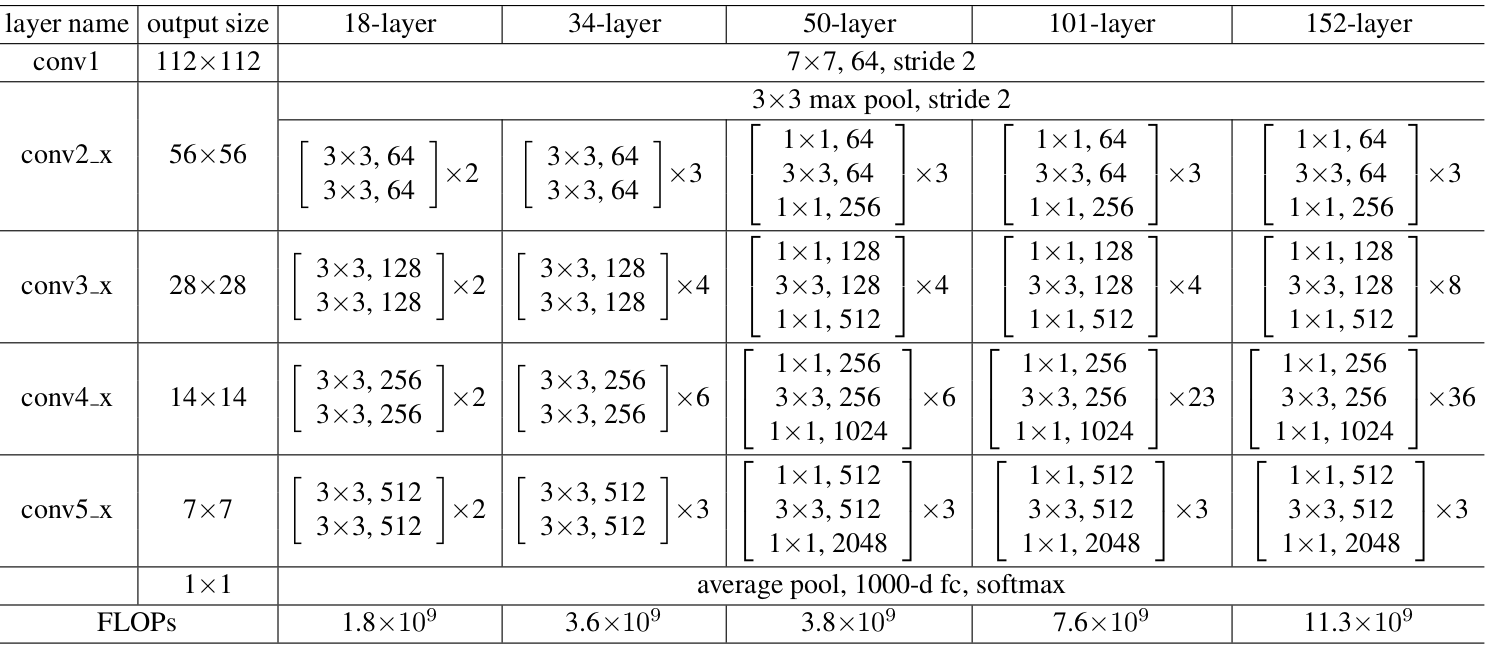

We see in Table 1 that the resnet 50 architecture contains the following element:

* A convolution with a core size of 7 * 7 and 64 different cores, all with a step size of 2, which gives us 1 layer.
* Next we see a maximum merge with a step size of 2.
* The next convolution has a 1 * 1.64 core, followed by a 3 * 3.64 core and finally a 1 * 1.256 core. These three layers are repeated a total of 3 times, giving us 9 layers in this step.
* Next we see core 1 * 1,128, then core 3 * 3,128 and finally core 1 * 1,512, this step has been repeated 4 times, giving us 12 layers in this step.
* After that there is a core 1 * 1,256 and two more cores with 3 * 3,256 and 1 * 1,1024, and this is repeated 6 times, giving us a total of 18 layers.
* And then again a 1 * 1,512 core with two more 3 * 3,512 and 1 * 1,2048 cores, and this is repeated 3 times, giving us a total of 9 layers.
* After that we do the middle pool and end it with a fully connected layer containing 1000 nodes and a softmax function at the end, so that gives us 1 layer.
* We don't really take into account the activation functions and the max/middle pooling of the layers.

so in total this gives us 1 + 9 + 12 + 18 + 9 + 1 = 50 layers of deep convolutional network.

### Convolutional Neural Network vs Fully connected neural network
Convolutional Neural Network:
* CNN architectures make the explicit assumption that the inputs are images, which allows certain properties to be encoded in the model architecture.
* A simple CNN is a sequence of layers, and each layer of the CNN converts one amount of activations to another using a differentiable function. Three basic types of layers are used to construct the CNN architecture: a convolutional layer, a merging layer, and a fully connected layer.
![](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

Fully connected neural network:
* A fully connected neural network consists of a series of fully connected layers that connect each neuron in one layer to each neuron in another layer.
* The main advantage of fully connected networks is that they are "structure independent", i.e., there is no need to make any special assumptions about the input data.
* Although structure-independent makes full-link networks very widely applicable, such networks tend to have lower performance than ad hoc networks tuned to the structure of the problem space.
![](https://www.researchgate.net/publication/331525817/figure/fig2/AS:733072932745216@1551789615161/Example-of-fully-connected-neural-network.png)

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## 3. Transfer learning
**Pre-trained model** - A model was previously trained using a large data set or advanced techniques that reduce the effort to train the model from scratch.

In **transfer learning**, the knowledge of an already trained machine learning model is applied to a different but related problem. For example, if you trained a simple classifier to predict whether an image contains a backpack, you could use the knowledge gained by the model during training to recognize other objects, such as sunglasses.

### Freezing wieghts
Layers and Models have three weight attributes:
* **weights** is a list of all weight variables in the layer.
**trainable_weights** is a list of those that must be updated (via gradient descent) to minimize losses during training.
**non_trainable_weights** is a list of those that are not intended for training. They are usually updated by the model during a direct pass.

**Freezing the model number** simply prevents the weight value from being updated during the update

In [ ]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):  
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model)

Change the last fully connection in parameters of model

In [ ]:
in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 5)
)

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias
fc.4.weight
fc.4.bias


Prepare the data set, classes are divided into folders

In [ ]:
data_tranform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        # нормализуем картинки по каналам
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    
])

# задаем датасет. Лейблы - имена папок: 
DATA_PATH = '/content/drive/MyDrive/Fall semester 2022/AI/lab 3/flowers'
dataset = ImageFolder(DATA_PATH, transform=data_tranform)

In [ ]:
dataset.imgs[2]

('/content/drive/MyDrive/Fall semester 2022/AI/lab 3/flowers/daisy/10172379554_b296050f82_n.jpg',
 0)

Split dataset into train and validation

Set datoaders - objects for iterative loading of data and labels for training and validation



In [2]:
batch_size = 32 

train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('The size of the training and validation dataset: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Optimizer and metrics

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters()) 
lr = 0.001 

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Utils

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:n}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")

Function save model information

In [ ]:
CP_PATH = '/content/drive/MyDrive/Fall semester 2022/AI/lab 3/model_cp.pt'

def save_checkpoint(checkpoint_path, model, epoch, optimizer, loss):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_path)
  
WEIGHTS_FNAME = '/content/drive/MyDrive/Fall semester 2022/AI/lab 3/weights.pth'
def save_weights(weights_fname, model):
  torch.save(model.state_dict(), weights_fname)

Create training and validting loop

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(1, epochs+1): # iterate over epochs
        for mode in ['training', 'validation']: # training - validation
            # calculate the gradient only when training:
            with torch.set_grad_enabled(mode == 'training'):
                # Depending on the phase, we translate the model into the desired mode:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # send tensor to GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # batch size (different for last batch in loader)
                    preds = model(imgs) # forward pass - run the tensor with pictures through the model
                    loss = F.cross_entropy(preds, labels) # calculate the loss function
                    acc = accuracy(preds, labels)# calculate the metric

                    # store loss and accuracy for the batch
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # if we are in the learning phase
                    if mode == 'training':
                        optimizer.zero_grad() # reset the previous gradient
                        loss.backward() # make a backward pass (calculate the gradient)
                        optimizer.step() # update the weights
            # at the end of the phase, display the values of loss and accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # save results across all epochs
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())

            # save checkpoint ervery epoch
            save_checkpoint(CP_PATH, model, epoch, optimizer, loss)
    return loss_track, accuracy_track  

Train model

In [ ]:
model.to(device) # Отправляем модель на GPU
optimizer = optimizer # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track


100%|██████████| 104/104 [05:24<00:00,  3.12s/it]


[training] Epoch: 1. Loss: 0.68. Accuracy: 73.92% 


100%|██████████| 32/32 [01:39<00:00,  3.10s/it]


[validation] Epoch: 1. Loss: 0.45. Accuracy: 84.10% 


100%|██████████| 104/104 [00:19<00:00,  5.21it/s]


[training] Epoch: 2. Loss: 0.54. Accuracy: 79.73% 


100%|██████████| 32/32 [00:06<00:00,  5.23it/s]


[validation] Epoch: 2. Loss: 0.46. Accuracy: 82.85% 


100%|██████████| 104/104 [00:19<00:00,  5.21it/s]


[training] Epoch: 3. Loss: 0.47. Accuracy: 82.41% 


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


[validation] Epoch: 3. Loss: 0.43. Accuracy: 84.17% 


100%|██████████| 104/104 [00:19<00:00,  5.26it/s]


[training] Epoch: 4. Loss: 0.43. Accuracy: 84.14% 


100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


[validation] Epoch: 4. Loss: 0.43. Accuracy: 84.22% 


100%|██████████| 104/104 [00:20<00:00,  4.98it/s]


[training] Epoch: 5. Loss: 0.40. Accuracy: 85.19% 


100%|██████████| 32/32 [00:06<00:00,  5.22it/s]


[validation] Epoch: 5. Loss: 0.42. Accuracy: 84.64% 


100%|██████████| 104/104 [00:19<00:00,  5.24it/s]


[training] Epoch: 6. Loss: 0.38. Accuracy: 86.08% 


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


[validation] Epoch: 6. Loss: 0.41. Accuracy: 85.37% 


100%|██████████| 104/104 [00:19<00:00,  5.27it/s]


[training] Epoch: 7. Loss: 0.36. Accuracy: 86.76% 


100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


[validation] Epoch: 7. Loss: 0.40. Accuracy: 85.73% 


100%|██████████| 104/104 [00:19<00:00,  5.25it/s]


[training] Epoch: 8. Loss: 0.34. Accuracy: 87.48% 


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


[validation] Epoch: 8. Loss: 0.39. Accuracy: 86.03% 


100%|██████████| 104/104 [00:19<00:00,  5.27it/s]


[training] Epoch: 9. Loss: 0.33. Accuracy: 87.98% 


100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


[validation] Epoch: 9. Loss: 0.39. Accuracy: 86.23% 


100%|██████████| 104/104 [00:19<00:00,  5.28it/s]


[training] Epoch: 10. Loss: 0.31. Accuracy: 88.51% 


100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


[validation] Epoch: 10. Loss: 0.39. Accuracy: 86.46% 


Evaluate model

In [ ]:
save_weights(WEIGHTS_FNAME, model)

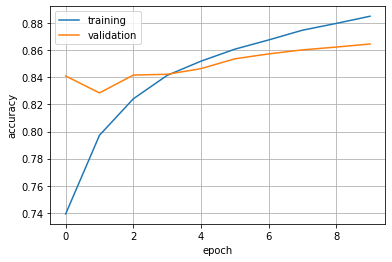

In [ ]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

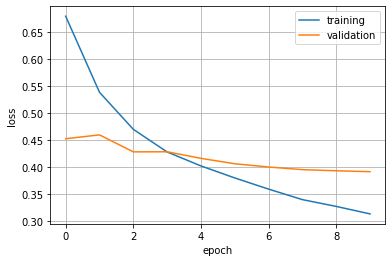

In [ ]:
plt.plot(loss_track['training'], label='training')
plt.plot(loss_track['validation'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

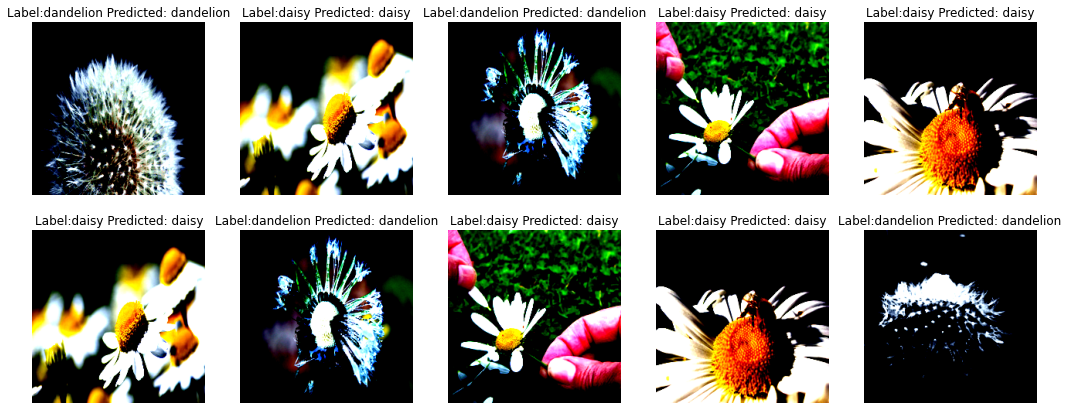

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

fig, axs = plt.subplots(2,5, figsize=(18,7))
for i in range(2):
  for j in range(5):
    img, label = val_set[i+j]
    axs[i,j].imshow(img.clip(0,1).permute(1, 2, 0))
    axs[i,j].axis('off')
    label = dataset.classes[label]
    pred = predict_image(img, model)
    title = 'Label:' + label+' Predicted: '+ pred
    axs[i,j].set_title(title)
plt.show()